In [9]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [10]:
import numpy as np
import emcee.backends.backend
from multiprocessing import Pool

from model_chain import run_chain_of_models_mcmc_without_pfss, get_ace_date
from sunpy.coordinates.sun import carrington_rotation_time
import sunpy.map
import warnings

In [11]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

In [12]:
# get data
# exclude 2051 since there were 3 CMEs during this time period.
list_of_carrington_rotations = [2048, 2049, 2050, 2052, 2053, 2054, 2055, 2056, 2057, 2058]
num_cr = len(list_of_carrington_rotations)
ACE_longitude = []
ACE_latitude = []
ACE_r = []
ACE_vr = []
ACE_obstime = []
gong_map = []

for cr in list_of_carrington_rotations:
    # get ace data
    start_time = carrington_rotation_time(int(cr)).to_datetime()
    end_time = carrington_rotation_time(int(cr) + 1).to_datetime()
    result = get_ace_date(start_time=start_time, end_time=end_time)
    ACE_longitude.append(result[0])
    ACE_latitude.append(result[1])
    ACE_r.append(result[2])
    ACE_vr.append(result[3])
    ACE_obstime.append(result[4])

    # get gong synoptic maps
    gong = sunpy.map.Map('GONG/CR' + str(cr) + '/cr' + str(cr) + '.fits.gz')
    gong.meta["bunit"] = u.gauss
    gong.meta["DATE"] = str(result[4][-1])
    gong.meta["DATE_OBS"] = str(result[4][-1])
    gong_map.append(gong)

In [15]:
def model():
    """The model evaluation used in MCMC for obtaining the radial velocity of 10 consecutive CRs.

    :param theta: list of model parameters.
    :return: list of radial velocity results.
    """
    # full list of parameters used in the chain of models, the last four are non-influential.
    coefficients_vec = [2.5, 250, 684, 0.18, 1.01, 0.01, 0.24, 1.75, 3, 0.15, 50]
    # vr initialization
    vr = []

    for jj in range(num_cr):
        vr.append(run_chain_of_models_mcmc_without_pfss(ACE_longitude=ACE_longitude[jj],
                                                        ACE_latitude=ACE_latitude[jj],
                                                        ACE_r=ACE_r[jj],
                                                        coefficients_vec=coefficients_vec,
                                                        cr=list_of_carrington_rotations[jj]))
    return vr

In [16]:
vr = model()

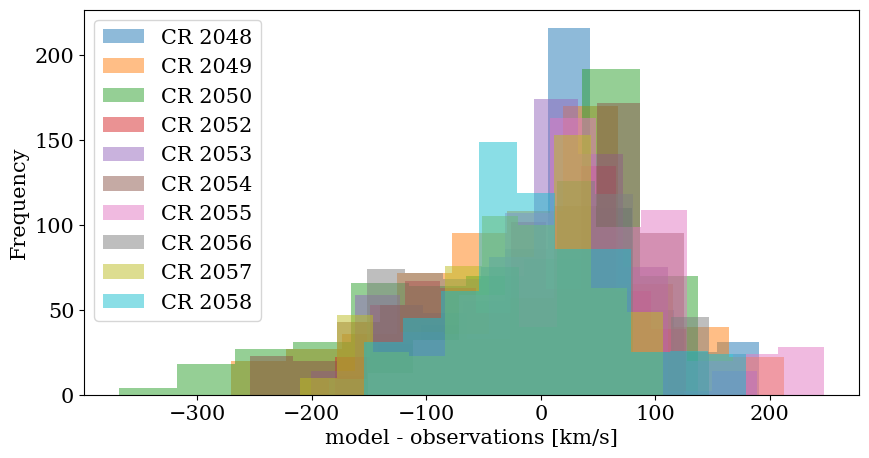

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
for ii in range(num_cr):
    ax.hist(vr[ii] - ACE_vr[ii].value, label="CR " + str(list_of_carrington_rotations[ii]), alpha=0.5)
ax.set_xlabel("model - observations [km/s]")
ax.set_ylabel("Frequency")
ax.legend()

In [60]:
dim = 0
for ii in range(num_cr):
    ACE_vr_is_nan = np.isnan(ACE_vr[ii])
    dim += len(vr[ii]) - len(np.where(np.isnan(ACE_vr[ii])))

In [61]:
dim

6537

In [63]:
error = np.zeros(dim)
jj = 0 
for ii in range(num_cr):
    ACE_vr_is_nan = np.isnan(ACE_vr[ii])
    error[jj:jj + len(vr[ii][~ACE_vr_is_nan])] = vr[ii][~ACE_vr_is_nan] - ACE_vr[ii].value[~ACE_vr_is_nan]
    jj += len(vr[ii][~ACE_vr_is_nan])

In [67]:
np.mean(error)

-1.9528166523818589

In [68]:
np.std(error)

86.04891753540538